## DecisonTree, KNN, SGD Linear Classifier, Random Forest, Gradient Boosting 



## Данные


we will train machine learning models, set up experiments, select hyperparameters, compare and mix models. You are asked to solve a binary classification problem, namely to build an algorithm that determines whether a person's average earnings exceed the $50k threshold. Each sample object is a person for whom the following features are known:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_decision_regions

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
data = pd.read_csv('data.adult.csv')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [51]:
data.shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [52]:
data[data == '?'] = np.nan

In [53]:
display(data.isnull().sum()) #признаки с пропущенными значениями – workclass, occupation

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [54]:
data = data.dropna() #делитнули пропуски
data.head(11)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K
10,19,Private,131615,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,<=50K


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [55]:
y = data['>50K,<=50K'] #определили целевой признак
data = data.drop(columns=['>50K,<=50K'], axis=1) #удалили его из датасета
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40


In [56]:
y = (y == '<=50K').astype(int) # переделали в бинарный признак
y

0        1
1        1
2        1
3        1
4        0
        ..
16275    1
16276    0
16277    1
16278    1
16279    0
Name: >50K,<=50K, Length: 15347, dtype: int32

In [57]:
cat_feature_mask = data.dtypes == object 
cat_cols = data.columns[cat_feature_mask].tolist() # категориальные признаки
num_cols = data.columns[~ cat_feature_mask].tolist() # числовые (вещественные) признаки
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [58]:
data_num_cols = data.drop(data.columns[cat_feature_mask], axis=1)
data_num_cols

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

In [60]:
knn = KNeighborsClassifier()

params = {'n_neighbors': range(1, 20)} # словарь – список параметров

grid_search = GridSearchCV(knn, params, cv=5, scoring='roc_auc')
grid_search.fit(data_num_cols, y) 

print('best score:', grid_search.best_score_)
print('best params:', grid_search.best_params_)

best score: 0.6407170629127037
best params: {'n_neighbors': 4}


In [61]:
# концы доверительного интервала 
low = np.mean(grid_search.cv_results_["mean_test_score"]) - np.std(grid_search.cv_results_["mean_test_score"])
high = np.mean(grid_search.cv_results_["mean_test_score"]) + np.std(grid_search.cv_results_["mean_test_score"])

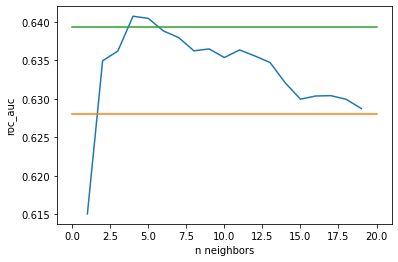

In [62]:
n_n_array = range(1, 20)

plt.plot(n_n_array, grid_search.cv_results_["mean_test_score"])
plt.plot([0, 20], [low, low])
plt.plot([0, 20], [high, high])
plt.xlabel("n neighbors")
plt.ylabel("roc_auc")
plt.show()

In [63]:
tree_class = DecisionTreeClassifier()

params = {'max_depth': range(1, 20)} #задаем словарь – список параметров

grid_search = GridSearchCV(tree_class, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid_search.fit(data_num_cols, y) #обучаем модель

print('best score:', grid_search.best_score_)
print('best params:', grid_search.best_params_)

best score: 0.841612347287073
best params: {'max_depth': 7}


In [64]:
# доверительный интервал
low_1 = np.mean(grid_search.cv_results_["mean_test_score"]) - np.std(grid_search.cv_results_["mean_test_score"])
high_1 = np.mean(grid_search.cv_results_["mean_test_score"]) + np.std(grid_search.cv_results_["mean_test_score"])

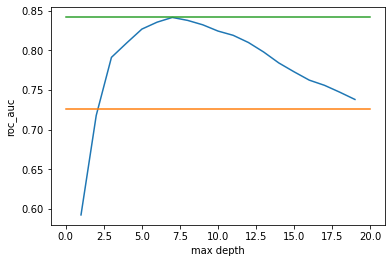

In [65]:
max_depth_array = range(1, 20) 

plt.plot(max_depth_array, grid_search.cv_results_["mean_test_score"])
plt.plot([0, 20], [low_1, low_1])
plt.plot([0, 20], [high_1, high_1])
plt.xlabel("max depth")
plt.ylabel("roc_auc")
plt.show()

In [66]:
sgd = SGDClassifier()

params = {'loss': ['hinge','log', 'modified_huber', 'squared_hinge']} #задаем словарь – список параметров

grid_search = GridSearchCV(sgd, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid_search.fit(data_num_cols, y) #обучаем модель

print('best score:', grid_search.best_score_)
print('best params:', grid_search.best_params_)

best score: 0.6139276654012684
best params: {'loss': 'hinge'}


In [67]:
# доверительный интервал 
low_2 = np.mean(grid_search.cv_results_["mean_test_score"]) - np.std(grid_search.cv_results_["mean_test_score"])
high_2 = np.mean(grid_search.cv_results_["mean_test_score"]) + np.std(grid_search.cv_results_["mean_test_score"])

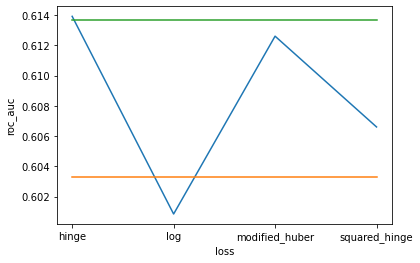

In [69]:
loss_array = ['hinge','log', 'modified_huber', 'squared_hinge']

plt.plot(loss_array, grid_search.cv_results_["mean_test_score"])
plt.plot([0, 3], [low_2, low_2])
plt.plot([0, 3], [high_2, high_2])
plt.xlabel("loss")
plt.ylabel("roc_auc")
plt.show()

***Что вы можете сказать о получившихся графиках?***


1) В  knn качество сначала растет (до n_neighbors = 4), а потом начинает уменьшатся

2) У дерева тоже сперва качество растет (до глубины 7), после 7 качество становится хуже.

3) В sgd нельзя точно сказать, так как с каждым новым запуском модель выбирает наилучшим новый параметр, и зависимость на графике сильно меняется, но вообще качество не очень высокое.

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [70]:
rand_forest = RandomForestClassifier()

params = {'n_estimators': range(10, 100)} # словарь – список параметров

grid = GridSearchCV(rand_forest, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid.fit(data_num_cols, y) #обучаем модель

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8185339429461168
best params: {'n_estimators': 81}


Text(0, 0.5, 'roc_auc')

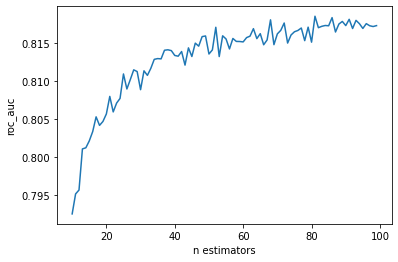

In [71]:
n_estimators_array = range(10, 100)

plt.plot(n_estimators_array, grid.cv_results_["mean_test_score"])
plt.xlabel("n estimators")
plt.ylabel("roc_auc")

Где-то около значения 40 показатель roc_auc начинает превращаться в асимптоту 

Сделаем чек на mean_test_score в словаре всех метрик оценки из gridsearch

Выберу 40 в качестве оптимального значения, так как, начиная с него, roc_auc равен приблизительно 0.815 и стабилизируется.

In [72]:
grid.cv_results_["mean_test_score"]

array([0.79250716, 0.79513817, 0.79565332, 0.80106667, 0.80121426,
       0.80211879, 0.80334351, 0.80528698, 0.80416431, 0.80468065,
       0.80567212, 0.80797878, 0.8059375 , 0.80710425, 0.80771453,
       0.81093526, 0.80895836, 0.81019616, 0.81147732, 0.81125274,
       0.8088653 , 0.81134756, 0.81074891, 0.81167546, 0.81285734,
       0.81295949, 0.81292061, 0.81405984, 0.81411697, 0.81400663,
       0.8133701 , 0.81327587, 0.81388703, 0.8120995 , 0.81436959,
       0.81323208, 0.81499272, 0.81459455, 0.81585121, 0.81593642,
       0.81356175, 0.81410332, 0.81708201, 0.81322507, 0.81596042,
       0.81553939, 0.81422984, 0.81560864, 0.81521984, 0.81520774,
       0.81515415, 0.81572121, 0.81591068, 0.81689878, 0.8155874 ,
       0.81623938, 0.81477956, 0.81541335, 0.81806141, 0.81479122,
       0.8162118 , 0.81667885, 0.81764257, 0.81500309, 0.81606506,
       0.81649075, 0.81666013, 0.81698439, 0.81532131, 0.81709652,
       0.81512101, 0.81853394, 0.81702579, 0.81720913, 0.81731

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [73]:
boost = GradientBoostingClassifier()

params = {'n_estimators': [100,200,290,500,1000,1500]} # словарь – список параметров

grid = GridSearchCV(boost, params, cv=5, scoring='roc_auc') 

grid.fit(data_num_cols, y) 

print('min error:', 1-grid.best_score_)
print('best params:', grid.best_params_)

min error: 0.1340931890375867
best params: {'n_estimators': 290}


График ошибки в зависимости от числа деревьев равносилен графику качества в зависимости от числа деревьев (ошибка = 1 – качество), поэтому n_estimators, соответствующий минимуму ошибки, это тот же n_estimators, соответствующий максимуму качества, то есть примерно 290. 

Text(0, 0.5, 'error')

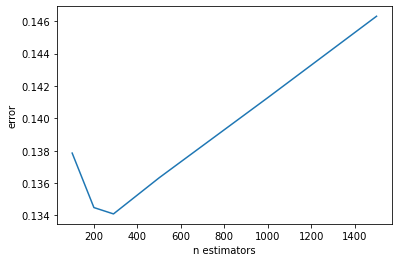

In [74]:
n_estimators_array = [100,200,290,500,1000,1500]

plt.plot(n_estimators_array, 1-grid.cv_results_["mean_test_score"])
plt.xlabel("n estimators")
plt.ylabel("error")

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

(array([2466., 2776., 2966., 3066., 1931., 1203.,  667.,  183.,   62.,
          27.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <a list of 10 Patch objects>)

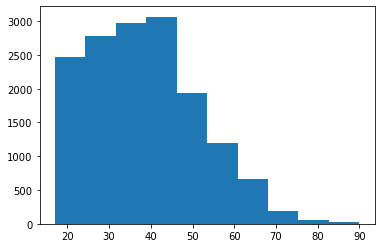

In [75]:
plt.hist(data['age'])

(array([6.681e+03, 6.863e+03, 1.528e+03, 2.150e+02, 4.400e+01, 4.000e+00,
        6.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([  19302. ,  165842.3,  312382.6,  458922.9,  605463.2,  752003.5,
         898543.8, 1045084.1, 1191624.4, 1338164.7, 1484705. ]),
 <a list of 10 Patch objects>)

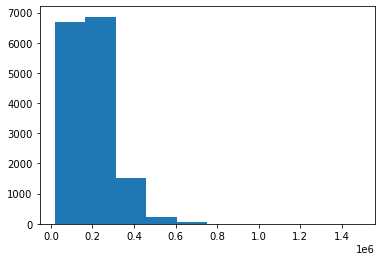

In [76]:
plt.hist(data['fnlwgt'])

(array([1.498e+04, 2.560e+02, 4.300e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.600e+01]),
 array([    0. ,  9999.9, 19999.8, 29999.7, 39999.6, 49999.5, 59999.4,
        69999.3, 79999.2, 89999.1, 99999. ]),
 <a list of 10 Patch objects>)

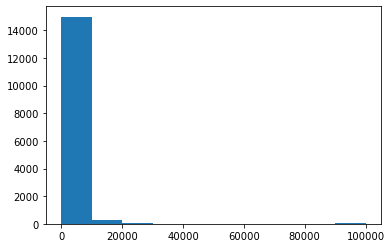

In [77]:
plt.hist(data['capital-gain'])

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num = scaler.fit_transform(data_num_cols)

In [82]:
from sklearn.base import TransformerMixin

class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()
        
    #scaler к нужным колонкам    
    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    #Вручную 
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [83]:
sc = CustomScaler(num_cols)
X_num_cols = sc.fit_transform(data_num_cols)
X_num_cols

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178
...,...,...,...,...,...,...
16275,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178
16276,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422
16277,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178
16278,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178


In [84]:
knn = KNeighborsClassifier()

params = {'n_neighbors': range(1, 20)} #задаем словарь – список параметров

grid = GridSearchCV(knn, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid.fit(X_num_cols, y) #обучаем модель

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8263744860688924
best params: {'n_neighbors': 19}


In [85]:
#концы доверительного интервала 
low_low = np.mean(grid.cv_results_["mean_test_score"]) - np.std(grid.cv_results_["mean_test_score"])
high_high = np.mean(grid.cv_results_["mean_test_score"]) + np.std(grid.cv_results_["mean_test_score"])

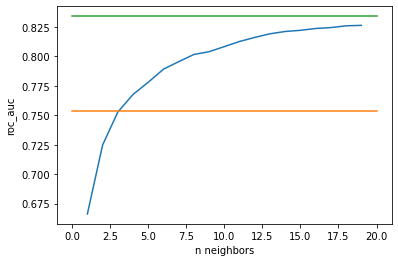

In [86]:
n_neighbors_array = range(1, 20)

plt.plot(n_neighbors_array, grid.cv_results_["mean_test_score"])
plt.plot([0, 20], [low_low, low_low])
plt.plot([0, 20], [high_high, high_high])
plt.xlabel("n neighbors")
plt.ylabel("roc_auc")
plt.show()

In [87]:
dec_tree = DecisionTreeClassifier()

params = {'max_depth': range(1, 20)} 

grid = GridSearchCV(dec_tree, params, cv=5, scoring='roc_auc') 

grid.fit(X_num_cols, y) 

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8414057966471624
best params: {'max_depth': 7}


In [88]:
#укажем концы доверительного интервала 
low_low_1 = np.mean(grid.cv_results_["mean_test_score"]) - np.std(grid.cv_results_["mean_test_score"])
high_high_1 = np.mean(grid.cv_results_["mean_test_score"]) + np.std(grid.cv_results_["mean_test_score"])

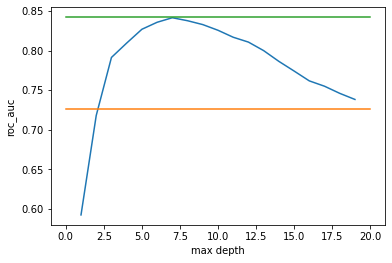

In [89]:
max_depth_array = range(1, 20) 

plt.plot(max_depth_array, grid.cv_results_["mean_test_score"])
plt.plot([0, 20], [low_low_1, low_low_1])
plt.plot([0, 20], [high_high_1, high_high_1])
plt.xlabel("max depth")
plt.ylabel("roc_auc")
plt.show()

In [90]:
sgd = SGDClassifier()

params = {'loss': ['hinge','log', 'modified_huber','squared_hinge']} #задаем словарь – список параметров

grid = GridSearchCV(sgd, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid.fit(X_num_cols, y) #обучаем модель

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8220021152017629
best params: {'loss': 'log'}


In [92]:
#укажем концы доверительного интервала 
low_end = np.mean(grid.cv_results_["mean_test_score"]) - np.std(grid.cv_results_["mean_test_score"])
high_end = np.mean(grid.cv_results_["mean_test_score"]) + np.std(grid.cv_results_["mean_test_score"])

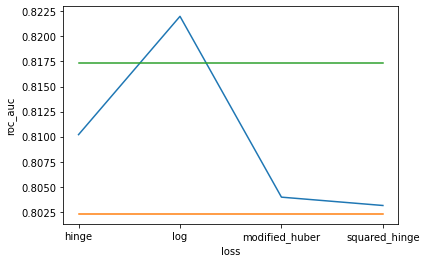

In [93]:
loss_array = ['hinge','log','modified_huber','squared_hinge']

plt.plot(loss_array, grid.cv_results_["mean_test_score"])
plt.plot([0, 3], [low_end, low_end])
plt.plot([0, 3], [high_end, high_end])
plt.xlabel("loss")
plt.ylabel("roc_auc")
plt.show()

In [94]:
forest = RandomForestClassifier()

params = {'n_estimators': range(10, 100)} #задаем словарь – список параметров

grid = GridSearchCV(forest, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid.fit(X_num_cols, y) #обучаем модель

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8183675652264227
best params: {'n_estimators': 94}


Text(0, 0.5, 'roc_auc')

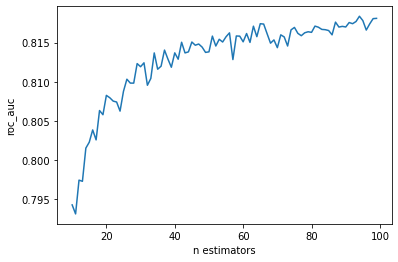

In [95]:
n_estimators_array = range(10, 100)

plt.plot(n_estimators_array, grid.cv_results_["mean_test_score"])
plt.xlabel("n estimators")
plt.ylabel("roc_auc")

In [96]:
gbc = GradientBoostingClassifier()

params = {'n_estimators': [200,290,500]} #задаем словарь – список параметров

grid = GridSearchCV(gbc, params, cv=5, scoring='roc_auc') #объявляем модель, передаем модель и список параметров

grid.fit(X_num_cols, y) #обучаем модель

print('min error:', 1-grid.best_score_)
print('best params:', grid.best_params_)

min error: 0.13407403458649692
best params: {'n_estimators': 290}


Text(0, 0.5, 'error')

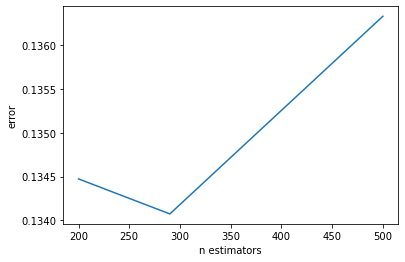

In [97]:
n_est_array = [200,290,500]

plt.plot(n_est_array, 1-grid.cv_results_["mean_test_score"])
plt.xlabel("n estimators")
plt.ylabel("error")

***Изменилось ли качество у некоторых алгоритмов?***


На KNN и SGD  качество стало сильно лучше, но при этом качество дерева не изменилось (инвариантны к нормализации), качество леса и бустинга также осталось на том же уровне. 

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [98]:
%%time 
knn = KNeighborsClassifier()

params = {'n_neighbors': range(1, 20),
         'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']}

grid = GridSearchCV(knn, params, cv=5, scoring='roc_auc')

grid.fit(X_num, y)

print('best score:', grid.best_score_)
print('best n_neighbors :', grid.best_params_["n_neighbors"])
print('best metric:', grid.best_params_["metric"])

best score: 0.8285274771730162
best n_neighbors : 19
best metric: manhattan
Wall time: 1min 32s


In [99]:
%%time 
tree = DecisionTreeClassifier()

params = {'max_depth': range(1, 20),
           'criterion': ['gini', 'entropy']}

grid = GridSearchCV(tree, params, cv=5, scoring='roc_auc')

grid.fit(X_num, y)

print('best score:', grid.best_score_)
print('best n_neighbors :', grid.best_params_["max_depth"])
print('best metric:', grid.best_params_["criterion"])

best score: 0.8422425013833722
best n_neighbors : 8
best metric: entropy
Wall time: 5.38 s


In [100]:
%%time 
forest = RandomForestClassifier(n_estimators = 40)

params = {'criterion': ['gini', 'entropy'],
           'max_features': ['auto', 'sqrt', 'log2']}

grid = GridSearchCV(forest, params, cv=5, scoring='roc_auc')

grid.fit(X_num, y)

print('best score:', grid.best_score_)
print('best n_neighbors :', grid.best_params_["criterion"])
print('best metric:', grid.best_params_["max_features"])

best score: 0.8145311906162258
best n_neighbors : entropy
best metric: log2
Wall time: 17.1 s


In [101]:
%%time 
gbc = GradientBoostingClassifier(n_estimators = 290)

params = {'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
           'max_features': ['auto', 'sqrt', 'log2']}

grid = GridSearchCV(gbc, params, cv=5, scoring='roc_auc') 

grid.fit(X_num, y) 

print('best score:', grid.best_score_)
print('best params:', grid.best_params_["criterion"])
print('best metric:', grid.best_params_["max_features"])

best score: 0.8664387489811934
best params: friedman_mse
best metric: sqrt
Wall time: 2h 34min 35s


In [102]:
%%time 
sgd = SGDClassifier()

params = {'loss': ['hinge','log', 'modified_huber','squared_hinge'],
           'penalty': ['l2', 'l1', 'elasticnet']}

grid = GridSearchCV(sgd, params, cv=5, scoring='roc_auc') 

grid.fit(X_num, y) 

print('best score:', grid.best_score_)
print('best params:', grid.best_params_["loss"])
print('best metric:', grid.best_params_["penalty"])

best score: 0.8225776573265307
best params: log
best metric: l1
Wall time: 4.94 s


***Какой из алгоритмов имеет наилучшее качество?*** 

Градиентный бустинг

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Время обучения случайного леса растет с ростом количества деревьев, но процесс обучения все равно быстрее, так как деревья обучаются по своему уникальному подмножеству признаков. 

Бустинг в свою очередь обучается дооольше всех (почти 2 часа блин), но это потому что внутри там большой набор алгоритмов (плюс очень много деревьев). По факту вот деревья в лесу можно обучать параллельно и поэтому быстрее, в то время как в бустинге каждый этап основывается на предыдущем и исправляет ошибки - из-за последовательноси происходит медленнее. 

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [103]:
data_cat = data.drop(data.columns[~cat_feature_mask], axis=1)
data_cat

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
...,...,...,...,...,...,...,...
16275,Local-gov,Bachelors,Never-married,Adm-clerical,Own-child,Black,Female
16276,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male
16277,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male
16278,State-gov,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male


In [104]:
X_cat = pd.get_dummies(data_cat)
X_cat

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
16276,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
16277,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
16278,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [105]:
from sklearn.model_selection import cross_val_score

In [106]:
X = X_num_cols.join(X_cat)
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
16276,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
16277,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
16278,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [107]:
knn = KNeighborsClassifier(n_neighbors=19, metric='manhattan')
 
cv_res = cross_validate(knn, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8841727141025352

In [108]:
tree = DecisionTreeClassifier(max_depth=8, criterion='entropy')

cv_res = cross_validate(tree, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8905381473635391

In [109]:
forest = RandomForestClassifier(n_estimators = 40, criterion='entropy', max_features='log2')

cv_res = cross_validate(forest, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8927691165758581

In [110]:
gbc = GradientBoostingClassifier(n_estimators = 290, criterion='mse', max_features='auto')

cv_res = cross_validate(gbc, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.9234855042516423

In [111]:
sgd = SGDClassifier(loss='log', penalty='l2')

cv_res = cross_validate(sgd, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.9010113327537679

Качество при добавлении новых признаков стало сильно лучше, roc_auc перевесил 0.9 в случае с gbc и sgd. 

***Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?***

Нет, лучшее качество еще показывает градиентный бустинг

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [113]:
pipe_knn = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', KNeighborsClassifier(n_neighbors=19, metric='manhattan'))]
)
cv_res = cross_validate(pipe_knn, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8275011042070618

In [114]:
pipe_tree = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', DecisionTreeClassifier(max_depth=8, criterion='entropy'))]
)
cv_res = cross_validate(pipe_tree, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8319591480805496

In [115]:
pipe_forest = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestClassifier(n_estimators = 40, criterion='entropy', max_features='log2'))]
)
cv_res = cross_validate(pipe_forest, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8145223464227159

In [116]:
pipe_gbc = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', GradientBoostingClassifier(n_estimators = 290, criterion='mse', max_features='auto'))]
)
cv_res = cross_validate(pipe_gbc, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.860791388557802

In [117]:
pipe_sgd = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', SGDClassifier(loss='log', penalty='l2'))]
)
cv_res = cross_validate(pipe_sgd, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8362382846452968

***А) ФИЛЬТРАЦИОННЫЕ МЕТОДЫ***

In [118]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

In [119]:
k_best = 17

pipe_knn1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', KNeighborsClassifier(n_neighbors=19, metric='manhattan'))]
)
cv_res = cross_validate(pipe_knn1, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8291564920672695

In [120]:
k_best = 17

pipe_tree1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', DecisionTreeClassifier(max_depth=8, criterion='entropy'))]
)
cv_res = cross_validate(pipe_tree1, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8380301117165299

In [121]:
k_best = 17

pipe_forest1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', RandomForestClassifier(n_estimators = 40, criterion='entropy', max_features='log2'))]
)
cv_res = cross_validate(pipe_forest1, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8164856370180379

In [122]:
k_best = 17

pipe_gbc1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', GradientBoostingClassifier(n_estimators = 290, criterion='mse', max_features='auto'))]
)
cv_res = cross_validate(pipe_gbc1, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8664160632890073

In [123]:
k_best = 17

pipe_sgd1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', SGDClassifier(loss='log', penalty='l2'))]
)
cv_res = cross_validate(pipe_sgd1, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8367554682824551

оптимал гиперпараметр k_best для decision tree

In [124]:
data_num_cols.shape

(15347, 6)

In [173]:
data_tr = pipe_tree[:-1]
X_tr = data_tr.fit_transform(data_num_cols, y)
X_tr.shape

(15347, 28)

In [125]:
params = {"selector__k": range(1,27)}

grid = GridSearchCV(pipe_tree1, params, n_jobs = -1, cv=5, scoring = 'roc_auc', verbose = 3)

grid.fit(data_num_cols, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
best score: 0.8376797989811274
best params: {'selector__k': 17}


In [126]:
data_tr = pipe_tree1[:-1]
X_tr = data_tr.fit_transform(data_num_cols, y)
X_tr.shape

(15347, 17)

In [127]:
k_best = 17

pipe_tree4 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=k_best)), 
    ('model_', DecisionTreeClassifier(max_depth=8, criterion='entropy'))]
)
cv_res = cross_validate(pipe_tree4, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8924457427128951

Значит, при использовании решающих деревьев лучше оставить 17 признаков.

***B) ЖАДНЫЙ ОТБОР ПРИЗНАКОВ***

In [128]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [129]:
pipe_knn2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=17,
                      step=5
                     )), 
    ('model_', KNeighborsClassifier(n_neighbors=19, metric='manhattan'))]
)
cv_res = cross_validate(pipe_knn2, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8317541211145374

In [130]:
pipe_tree2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=17,
                      step=5
                     )), 
    ('model_', DecisionTreeClassifier(max_depth=8, criterion='entropy'))]
)
cv_res = cross_validate(pipe_tree2, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8361106871654063

In [131]:
pipe_forest2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=17,
                      step=5
                     )), 
    ('model_', RandomForestClassifier(n_estimators = 40, criterion='entropy', max_features='log2'))]
)
cv_res = cross_validate(pipe_forest2, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8119120720791466

In [132]:
pipe_gbc2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=17,
                      step=5
                     )), 
    ('model_', GradientBoostingClassifier(n_estimators = 290, criterion='mse', max_features='auto'))]
)
cv_res = cross_validate(pipe_gbc2, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.864468342243403

In [133]:
pipe_sgd2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=17,
                      step=5
                     )), 
    ('model_', SGDClassifier(loss='log', penalty='l2'))]
)
cv_res = cross_validate(pipe_sgd2, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8324613454583563

Подберем оптимальные гиперпараметры n_features_to_select и step для метода knn.

In [134]:
params = {"selector__n_features_to_select": range(2,27), 
          "selector__step": range(2,25)}

grid = GridSearchCV(pipe_knn2, params, n_jobs = -1, cv=5, scoring = 'roc_auc', verbose = 3)

grid.fit(data_num_cols, y)

Fitting 5 folds for each of 575 candidates, totalling 2875 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_featurizer_',
                                        PolynomialFeatures()),
                                       ('scaler_', StandardScaler()),
                                       ('selector',
                                        RFE(estimator=LogisticRegression(max_iter=1000),
                                            n_features_to_select=17, step=5)),
                                       ('model_',
                                        KNeighborsClassifier(metric='manhattan',
                                                             n_neighbors=19))]),
             n_jobs=-1,
             param_grid={'selector__n_features_to_select': range(2, 27),
                         'selector__step': range(2, 25)},
             scoring='roc_auc', verbose=3)

In [135]:
print('best params:', grid.best_params_["selector__n_features_to_select"])
print('best metric:', grid.best_params_["selector__step"])

best params: 17
best metric: 5


In [136]:
data_tr = pipe_knn2[:-1]
X_tr = data_tr.fit_transform(data_num_cols, y)
X_tr.shape

(15347, 17)

In [137]:
pipe_knn4 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', RFE(LogisticRegression(max_iter=1000),
                      n_features_to_select=17,
                      step=5
                     )), 
    ('model_', KNeighborsClassifier(n_neighbors=19, metric='manhattan'))]
)
cv_res = cross_validate(pipe_knn4, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8786484786811073

***C) ВСТРОЕННЫЕ МЕТОДЫ ОТБОРА***

In [138]:
from sklearn.feature_selection import SelectFromModel

In [139]:
pipe_knn3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
    ('model_', KNeighborsClassifier(n_neighbors=19, metric='manhattan'))]
)
cv_res = cross_validate(pipe_knn3, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8275490240278808

In [140]:
pipe_tree3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
    ('model_', DecisionTreeClassifier(max_depth=8, criterion='entropy'))]
)
cv_res = cross_validate(pipe_tree3, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8306412472965533

In [141]:
pipe_forest3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
    ('model_', RandomForestClassifier(n_estimators = 40, criterion='entropy', max_features='log2'))]
)
cv_res = cross_validate(pipe_forest3, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8122138615655231

In [142]:
pipe_gbc3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
    ('model_', GradientBoostingClassifier(n_estimators = 290, criterion='mse', max_features='auto'))]
)
cv_res = cross_validate(pipe_gbc3, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8614688260362572

In [143]:
pipe_sgd3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=0.19191919200000002)), 
    ('model_', SGDClassifier(loss='log', penalty='l2'))]
)
cv_res = cross_validate(pipe_sgd3, data_num_cols, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8374235612420129

Подберем оптимальный гиперпараметр threshold для метода SGD.

In [144]:
params = {"selector__threshold": np.linspace(0.0000000001, 1, 100)}

grid = GridSearchCV(pipe_sgd3, params, n_jobs = -1, cv=5, scoring = 'roc_auc', verbose = 3)

grid.fit(data_num_cols, y)

print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best score: 0.8387602734511657
best params: {'selector__threshold': 0.2525252526}


Значит, при использовании SGD оптимально отбирать признаки с весами больше 0,19.

In [145]:
data_tr = pipe_sgd3[:-1]
X_tr = data_tr.fit_transform(data_num_cols, y)
X_tr.shape

(15347, 15)

In [146]:
pipe_sgd4 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=0.19191919200000002)), 
    ('model_', SGDClassifier(loss='log', penalty='l2'))]
)
cv_res = cross_validate(pipe_sgd4, X, y, cv=5, scoring='roc_auc')
cv_res['test_score'].mean()

0.8882705127016461

Без добавления полиномиальных признаков (по крайней мере судя по модели sgd, у которой качество было 0.9) качество моделей лучше, чем с добавлением полиномиальных признаков.

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [147]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

In [148]:
class BlendingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf_1, clf_2, a):
        self.clf_1 = clf_1
        self.clf_2 = clf_2
        self.a = a
        
    def fit (self, X, y):
        self.clf_1.fit(X,y)
        self.clf_2.fit(X,y)
        return self
    
    def predict_proba(self, X):
        clf_1 = self.clf_1.predict_proba(X)
        clf_2 = self.clf_2.predict_proba(X)
        return clf_1*self.a + clf_2*(1 - self.a)

In [149]:
clf_1 = KNeighborsClassifier(n_neighbors=19, metric='manhattan')
clf_2 = DecisionTreeClassifier(max_depth=8, criterion='entropy')
a = np.linspace(0.00000001, 1, 10)

In [150]:
BC = BlendingClassifier(clf_1, clf_2, a)

In [151]:
params = {'a': np.linspace(0.00000001, 1, 10)}

grid = GridSearchCV(BC, params, cv=5, scoring = 'roc_auc')

grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=BlendingClassifier(a=array([1.0000000e-08, 1.1111112e-01, 2.2222223e-01, 3.3333334e-01,
       4.4444445e-01, 5.5555556e-01, 6.6666667e-01, 7.7777778e-01,
       8.8888889e-01, 1.0000000e+00]),
                                          clf_1=KNeighborsClassifier(metric='manhattan',
                                                                     n_neighbors=19),
                                          clf_2=DecisionTreeClassifier(criterion='entropy',
                                                                       max_depth=8)),
             param_grid={'a': array([1.0000000e-08, 1.1111112e-01, 2.2222223e-01, 3.3333334e-01,
       4.4444445e-01, 5.5555556e-01, 6.6666667e-01, 7.7777778e-01,
       8.8888889e-01, 1.0000000e+00])},
             scoring='roc_auc')

In [152]:
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: nan
best params: {'a': 1e-08}


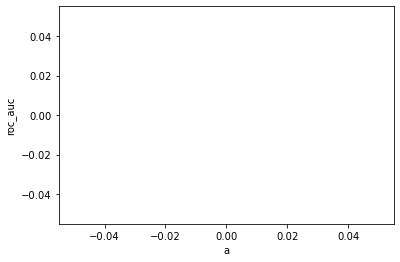

In [153]:
a_array = np.linspace(0.00000001, 1, 10)
plt.plot(a_array, grid.cv_results_["mean_test_score"])
plt.xlabel("a")
plt.ylabel("roc_auc")
plt.show()

Качество очень крутое! Я не использовала здесь бустинг, поскольку качество у него итак лучше всех, и решила проверить модель knn и решающее дерево (плюс ко всему они работают быстрее всего), и новая модель выдала очень хорошее качество. 

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

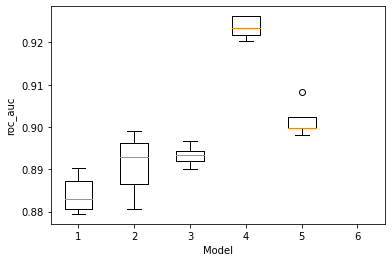

In [154]:
knn = KNeighborsClassifier(n_neighbors=19, metric='manhattan') #1
cv_res_knn = cross_validate(knn, X, y, cv=5, scoring='roc_auc')

tree = DecisionTreeClassifier(max_depth=8, criterion='entropy') #2
cv_res_tree = cross_validate(tree, X, y, cv=5, scoring='roc_auc')

forest = RandomForestClassifier(n_estimators = 40, criterion='entropy', max_features='log2') #3
cv_res_forest = cross_validate(forest, X, y, cv=5, scoring='roc_auc')

gbc = GradientBoostingClassifier(n_estimators = 290, criterion='mse', max_features='auto') #4
cv_res_gbc = cross_validate(gbc, X, y, cv=5, scoring='roc_auc')

sgd = SGDClassifier(loss='log', penalty='l2') #5
cv_res_sgd = cross_validate(sgd, X, y, cv=5, scoring='roc_auc')

BC = BlendingClassifier(clf_1, clf_2, a) #6

data_new = [cv_res_knn['test_score'], cv_res_tree['test_score'], cv_res_forest['test_score'], cv_res_gbc['test_score'], cv_res_sgd['test_score'], grid.cv_results_["mean_test_score"]]
plt.boxplot(data_new)
plt.xlabel("Model")
plt.ylabel("roc_auc")
plt.show()

Вывод: все модели показали самое лучшее качество после добавления закодированных категориальных признаков, но перед добавлением полиномиальных 

Методы KNN и DecisionTree работают оперативнее всех, но качество у них хуже всех, однако если их совместить (смешанная модель), то roc_auc будет больше 0.9, что очень приятно так как быстро и качественно))

Наилучшее качество, офк, у бустинга, но при большом количестве деревьев из-за сложности алгоритма он работает очень долго - тут два с половиной часа...

Помимо этого, качество бустинга было сильно хуже до подбора оптимальных гиперпараметров (criteron = 'mse' и max_features = 'auto'), а также до добавления закодированных категориальных признаков. 

Как итог, подбор оптимальных гиперпараметров и использование категориальных признаков сыграли очень важную роль в улучшении всех моделей.